# 第12章 ニューラルネットワーク - 画像認識トレーニング

- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
- ディープラーニング(deep learning)
- 人工ニューラルネットワーク(artificial neural network)

- 多層ニューラルネットワークの概念を理解する
- 画像を分類するためのニューラルネットワークをトレーニングする
- ニューラルネットワークをトレーニグするための強力なバッグプロパゲーションアルゴリズムを実装する
- ニューラルネットワークの実装をデバッグする

## 12.1 人工ニューラルネットワークによる複雑な関数のモデリング

- McCullochPittニューロンモデル
- バックプロパゲーション(backpropagation)アルゴリズム
- 特徴抽出器(feature detector)

### 12.1.1 単層ニューラルネットワークのまとめ

- ADALINE(ADAptive LInear NEuron)
- 勾配降下法
- エポック(データセットのトレーニング回数)
- 誤差平方和(SSE)
- コスト関数 J(w)
- 学習率η
- ニューロンの活性(activation)
- しきい値関数(ヘビサイド関数)

### 12.1.2 多層ニューラルネットワークアーキテクチャ

- 多層フィードフォワードニューラルネットワーク(multi-layer feedforward neural network)
- 多層パーセプトロン(Multi-Layer Parceptron: MLP)
- 隠れ層(hidden layer)

### 12.1.3 フォワードプロパゲーションによるニューラルネットワークの活性化

- フォワードプロパゲーション(順伝搬法、forward propagation)

1. 入力層を出発点として、トレーニングデータのパターンをネットワーク経由で順方向に伝搬させ、出力を生成する。
2. ネットワークの出力に基づき、後ほど説明するコスト関数を使って誤差を計算する。この誤差を最小化することが目的となる。
3. 誤差を逆方向に伝搬させることで、ネットワーク内の各重みに対する偏導関数を求め、モデルを更新する。

## 12.2 手書きの数字を分類する

- MNIST(Mixed National Istitute of Standards and Technology)データセット

### 12.2.1 MNISTデータセットを取得する

- http://yann.lecun.com/exdb/mnist/

In [17]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """
    MNISTデータをpathからロード
    """
    # 引数に指定したパスを結合(ラベルや画像のパスを作成)
    labels_path = os.path.join(path, '{}-labels-idx1-ubyte'.format(kind))
    images_path = os.path.join(path, '{}-images-idx3-ubyte'.format(kind))
    
    # ファイルを読み込む
    with open(labels_path, 'rb') as lbpath:
        # バイナリを文字列に変換: npack関数の引数にフォーマット、8バイト分の
        # バイナリデータを指定してマジックナンバー、アイテムの個数を読み込む
        magic, n = struct.unpack('>II', lbpath.read(8))
        # ファイルからラベルを読み込み配列を構築: fromfile関数の引数に
        # ファイル、配列のデータ形式を指定
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        # 画像ピクセル情報の配列のサイズを変更
        # (行数: ラベルのサイズ、列数: 特徴量の個数
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

images

- トレーニングデータセット: 60,000個
- テストデータセット: 10,000個
- 28x28 ピクセルの画像(784ピクセル)
- 各ピクセルはグレースケールの輝度(明暗)

labels

- 目的変数は手書き数字のクラスラベル(0〜9の整数)

In [20]:
X_train, y_train = load_mnist('chapter12', kind='train')
print('Rows: {:d}, columns: {}'.format(X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('chapter12', kind='t10k')
print('Rows: {:d}, columns: {}'.format(X_test.shape[0], X_test.shape[1]))


Rows: 60000, columns: 784
Rows: 10000, columns: 784


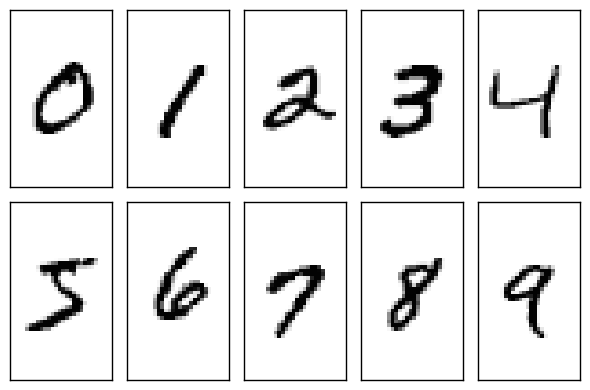

In [28]:
# 0〜9の数字の例を可視化する

import matplotlib.pyplot as plt
# subplots で描画の設定: 引数で描画領域の行数 / 列数、x/y 実の統一を指定
flg, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
# 配列を1次元に変換
ax = ax.flatten()
for i in range(10):
    # 配列を 28x28 に変形
    img = X_train[y_train == i][0].reshape(28, 28)
    # 色や補完方法を指定
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

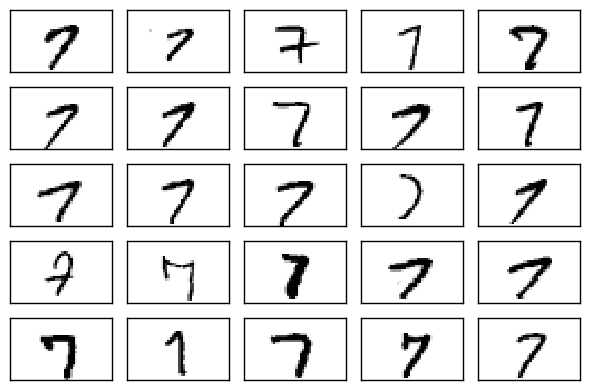

In [23]:
# 数字7のサンプルを25個ヒョ持する

import matplotlib.pyplot as plt
flg, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
# 配列を1次元に変換
ax = ax.flatten()
for i in range(len(ax)):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys", interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [29]:
# MNISTの画像データをCSVファイルとして保存する
if False:
    np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
    np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
    np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
    np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')

# MNISTの画像データをCSVファイルから読み込む
if False:
    X_train = np.genfromtxt('train_img.csv', fmt='%i', delimiter=',')
    y_train = np.savetxt('train_labels.csv', fmt='%i', delimiter=',')
    X_test = np.savetxt('test_img.csv', fmt='%i', delimiter=',')
    y_test = np.savetxt('test_labels.csv', fmt='%i', delimiter=',')